<h1> Facial Expression Recognition Using Deep Learning

---
- This model is designed to recognize human facial expressions from grayscale images. It classifies images into distinct emotional categories such as happy, sad, anger and surprise, based on visual features extracted from facial patterns. The goal is to enable accurate emotion detection using computer vision techniques, which can be applied in areas like human-computer interaction, mental health monitoring and intelligent surveillance systems.

<h1> Importing Required Libraries

---
- Description :
This step imports all the essential libraries needed for data manipulation, image processing, visualization, and deep learning.
- Purpose :
This section imports the essential Python libraries needed for data processing, visualization, and deep learning model development. Libraries like TensorFlow and Keras are used for model creation, while NumPy and Pandas handle data manipulation.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import zipfile
import torch
import tensorflow as tf
import matplotlib.patches as patches
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from re import L
from PIL import Image, UnidentifiedImageError
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.layers import Dense , Input , Dropout , GlobalAveragePooling2D , Flatten , Conv2D , BatchNormalization , Activation , MaxPooling2D , Dropout , Flatten
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score ,  confusion_matrix

<h1> Dataset Extraction

---
- Description :
The dataset is extracted and loaded into the environment, often from external storage such as Google Drive.
- Purpose :
To access and prepare the raw image dataset for processing and model training.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset = "/content/drive/MyDrive/Face Emotion Recognition Dataset.zip"
extract_data = "/content/dataset"
expression_data = '/content/dataset/images/'

with zipfile.ZipFile(dataset , 'r') as zip :
    zip.extractall(extract_data)

In [ ]:
for root , dirs , files in os.walk('/content/dataset/images'):
    print(f"Directory: {root}")
    for d in dirs:
        print(f"  Subdirectory: {d}")
    for f in files[:5]:
        print(f"  File: {f}")
    break

Directory: /content/dataset/images
  Subdirectory: train
  Subdirectory: validation
  Subdirectory: images


In [ ]:
train_data = '/content/dataset/images/train'
test_data = '/content/dataset/images/validation'

In [ ]:
def count_exp_side_by_side(train_data, test_data):
    train_dict = {}
    test_dict = {}

    for expression in os.listdir(train_data):
        train_dir = os.path.join(train_data, expression)
        train_dict[expression] = len(os.listdir(train_dir))

    for expression in os.listdir(test_data):
        test_dir = os.path.join(test_data, expression)
        test_dict[expression] = len(os.listdir(test_dir))

    all_classes = sorted(set(train_dict.keys()).union(set(test_dict.keys())))
    data = {'Train': [train_dict.get(cls, 0) for cls in all_classes] , 'Test': [test_dict.get(cls, 0) for cls in all_classes]}

    df = pd.DataFrame(data, index=all_classes)
    return df

count_df = count_exp_side_by_side(train_data, test_data)
print(count_df)

          Train  Test
angry      3993   960
disgust     436   111
fear       4103  1018
happy      7164  1825
neutral    4982  1216
sad        4938  1139
surprise   3205   797


<h1> Data Cleaning : Removing Blank Or Corrupted Images

---
- Description :
Invalid, blank, or corrupted image files are identified and removed from the dataset.
- Purpose :
Before training, it's important to ensure the dataset doesn't contain unreadable or corrupted image files that could cause runtime errors or degrade model performance.
- Result :
           🔹 Number Of Images Removed : 13

In [ ]:
def is_blank_or_corrupt(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return True
        return np.std(img) < 1
    except Exception:
        return True

In [ ]:
def clean_dataset_folder(folder_path):
    removed_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(root, file)
                if is_blank_or_corrupt(full_path):
                    removed_files.append(full_path)
                    os.remove(full_path)
    return removed_files

In [ ]:
train_removed = clean_dataset_folder(train_data)
test_removed = clean_dataset_folder(test_data)

print(f" Removed {len(train_removed)} images from train folder.")
print(f" Removed {len(test_removed)} images from test folder.")


✅ Removed 10 images from train folder.
✅ Removed 3 images from test folder.


<h1> Class Distribution in Train and Test Sets

---
-  Description :
This bar chart shows the number of images available per emotion class in both the training and testing datasets.
- Purpose :
To visualize the class balance across the dataset. This helps identify whether the dataset is imbalanced, which can affect model performance and bias the predictions toward overrepresented classes.
- Result :
           🔹 The dataset is imbalanced, with significantly more images labeled as "happy" (7164 train / 1825 test), "neutral", and "sad" compared to "disgust" (436 train / 111 test) and "surprise".
           🔹 Such imbalances may cause the model to perform better on dominant classes and worse on underrepresented ones.





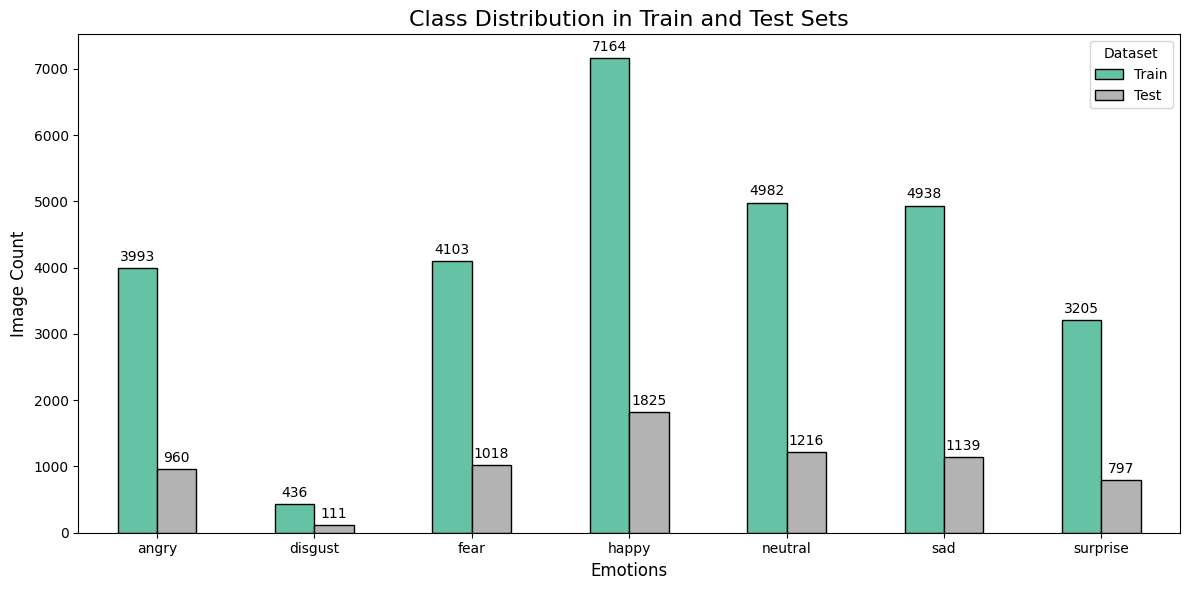

In [ ]:
ax = count_df.plot(kind = 'bar', figsize = (12, 6), colormap = 'Set2', edgecolor = 'black')

plt.title("Class Distribution in Train and Test Sets", fontsize=16)
plt.xlabel("Emotions", fontsize = 12)
plt.ylabel("Image Count", fontsize = 12)
plt.legend(title = 'Dataset')
plt.xticks(rotation = 0)
plt.grid(False)
plt.tight_layout()

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.annotate(f'{int(height)}', xy = (bar.get_x() + bar.get_width() / 2, height), xytext = (0, 3), textcoords = "offset points", ha = 'center', va = 'bottom', fontsize = 10)

plt.show()

<h1> Visualizing Sample Facial Expressions

---
- Description :
A few random images from each emotion class are displayed.
- Purpose :
To get an initial understanding of the dataset and confirm the data is correctly labeled and formatted.

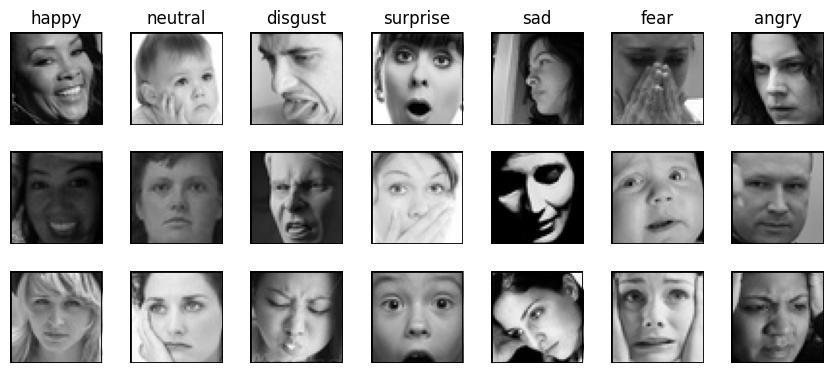

In [ ]:
expressions = os.listdir(train_data)
num_rows = 3
num_cols = len(expressions)

plt.figure(figsize = (num_cols * 1.5, num_rows * 1.5))

for col_idx, expression in enumerate(expressions) :
    expression_path = os.path.join(train_data, expression)
    img_list = os.listdir(expression_path)

    img_list = img_list[:3] if len(img_list) >= 3 else img_list

    for row_idx in range(len(img_list)):
        img_path = os.path.join(expression_path, img_list[row_idx])
        img = load_img(img_path)

        plt_idx = row_idx * num_cols + col_idx + 1
        ax = plt.subplot(num_rows, num_cols, plt_idx)
        ax.imshow(img)
        ax.axis('off')

        if row_idx == 0:
            ax.set_title(expression, fontsize=12)

        rect = patches.Rectangle((0, 0), 1, 1,transform = ax.transAxes , linewidth = 2 , edgecolor = 'black' , facecolor = 'none')
        ax.add_patch(rect)

plt.subplots_adjust(wspace=0.3,hspace=0.1)
plt.show()

<h1> Mapping Image Paths to Emotion Labels

---
- Description :
Each image file path is paired with its corresponding emotion label.
- Purpose :
To organize the data in a structured format for further processing and modeling.

In [ ]:
def createdataframe(dir):
  image_paths = []
  labels =[]
  for label in os.listdir(dir):
    for imagename in os.listdir(os.path.join(dir,label)):
      image_paths.append(os.path.join(dir,label,imagename))
      labels.append(label)
    print(label)
  return image_paths,labels

In [ ]:
train = pd.DataFrame()
train['image'],train['label'] = createdataframe(train_data)

test = pd.DataFrame()
test['image'],test['label'] = createdataframe(test_data)

happy
neutral
disgust
surprise
sad
fear
angry
happy
neutral
disgust
surprise
sad
fear
angry


<h1> Image Preprocessing and Reshaping

---

- Description :
Grayscale images are loaded, resized to a consistent shape (e.g., 48x48), and reshaped for model input.
- Purpose :
To standardize input dimensions for the neural network and ensure consistency during training.

In [ ]:
def extract_features(images):
  features = []
  for image in tqdm(images):
    img = load_img(image , color_mode='grayscale')
    img = np.array(img)
    features.append(img)
  features = np.array(features)
  features = features.reshape(len(features),48,48,1)
  return features

In [ ]:
train_features = extract_features(train['image'])
test_features = extract_features(test['image'])

  0%|          | 0/28811 [00:00<?, ?it/s]

  0%|          | 0/7063 [00:00<?, ?it/s]

<h1> Normalizing Image Pixel Value

---
- Description :
Pixel values are scaled (e.g., from 0–255 to 0–1).
- Purpose :
To speed up training and improve model convergence by normalizing input data.

In [ ]:
x_train = train_features/255.0
x_test = test_features/255.0

<h1> Encoding Emotion Labels to Integers

---
- Description :
Emotion labels (like “happy” or “sad”) are converted into numeric codes.
- Purpose :
To prepare categorical labels for model training, as most models work with numeric data.

In [ ]:
lb = LabelEncoder()
lb.fit(train['label'])

LabelEncoder()

In [ ]:
y_train = lb.transform(train['label'])
y_test = lb.transform(test['label'])

<h1> Applying One-Hot Encoding to Labels

---
- Description :
Integer-encoded labels are converted into binary class matrices.
- Purpose :
To allow the model to treat each class independently in a multi-class classification task.

In [ ]:
y_train = to_categorical(y_train,num_classes = 7)
y_test = to_categorical(y_test,num_classes = 7)

<h1> Building the Facial Expression Recognition Model

---
- Description :
A convolutional neural network (CNN) is constructed with layers suited for image recognition tasks.
- Purpose :
To create a deep learning model capable of learning and classifying emotional expressions from facial images.

In [ ]:
Classes = 7
input_shape = (48,48,1)
model = Sequential()

# 1st Layer
model.add(Conv2D(128,kernel_size = (3,3) , activation = 'relu' , input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2 , 2)))
model.add(Dropout(0.4))

# 2nd Layer
model.add(Conv2D(256,kernel_size = (3,3) , activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2 , 2)))
model.add(Dropout(0.4))

# 3rd Layer
model.add(Conv2D(512,kernel_size = (3,3) , activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2 , 2)))
model.add(Dropout(0.4))

# 4th Layer
model.add(Conv2D(512,kernel_size = (3,3) , activation = 'relu' ))
model.add(MaxPooling2D(pool_size = (2 , 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(256,activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(Classes , activation = "softmax"))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<h1> Evaluating Model Accuracy

---
- Description :
The final accuracy score is computed on the validation or test set.
- Purpose :
To measure how well the model generalizes to unseen data.

In [ ]:
history = model.fit(x = x_train , y = y_train , batch_size = 128 , epochs = 100 , validation_data = (x_test , y_test))

Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.2405 - loss: 1.8342 - val_accuracy: 0.2584 - val_loss: 1.8129
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.2523 - loss: 1.8081 - val_accuracy: 0.2571 - val_loss: 1.7912
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.2628 - loss: 1.7697 - val_accuracy: 0.3283 - val_loss: 1.6660
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.3247 - loss: 1.6738 - val_accuracy: 0.4014 - val_loss: 1.5495
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.3796 - loss: 1.5720 - val_accuracy: 0.4593 - val_loss: 1.3973
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.4283 - loss: 1.4735 - val_accuracy: 0.4800 - val_loss: 1.3351
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.4383 - loss: 1.4324 - val_accuracy: 0.5019 - val_loss: 1.2944
Epoch 8/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.4619 - loss: 1

<h1> Training and Validation Performance Across Epochs

---
- Description :
Graphs showing the loss and accuracy over training epochs for both training and validation sets.
- Purpose :
To visually track model performance and identify issues like overfitting or underfitting.
- Results :     
          🔹 Final Training Accuracy : 71.5%
          🔹 Final Validation Accuracy : 63.5%
          🔹 Final Training Loss : 0.78
          🔹 Final Validation Loss : 1.03

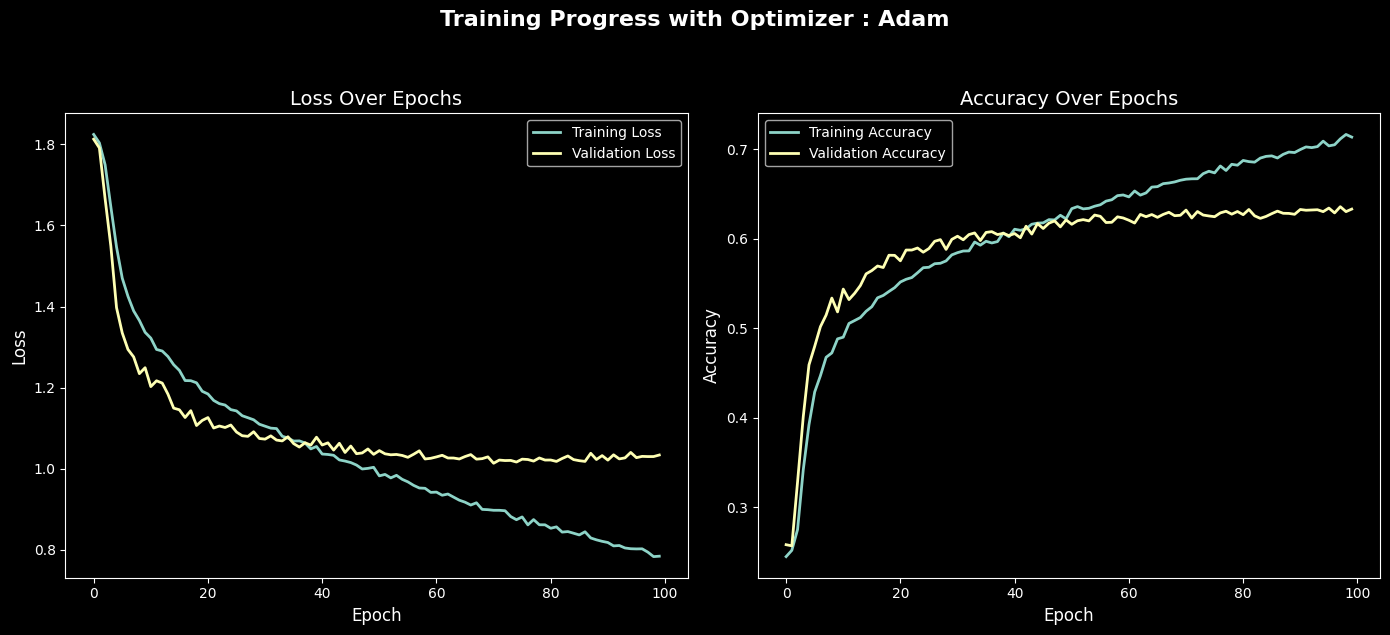

In [ ]:
plt.style.use("dark_background")
plt.figure(figsize = (14 , 6))

plt.suptitle("Training Progress with Optimizer : Adam", fontsize = 16, fontweight = 'bold', y = 1.05)

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"] , label = "Training Loss", linewidth = 2)
plt.plot(history.history["val_loss"], label = "Validation Loss", linewidth = 2)
plt.title('Loss Over Epochs', fontsize = 14)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.legend(loc = "upper right")


plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label = "Training Accuracy", linewidth = 2)
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy", linewidth = 2)
plt.title('Accuracy Over Epochs', fontsize = 14)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend(loc = "upper left")

plt.tight_layout()
plt.show()

<h1> Performance Evaluation : True vs Predicted Outputs

---
- Description :
This section compares the model’s predicted labels with the actual emotion labels to assess classification accuracy.

- Purpose :
To evaluate how accurately the model identifies emotions and spot common misclassifications.

- Result : The model reached a validation accuracy of 63.5%, showing good performance but with some confusion between similar emotions.



221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


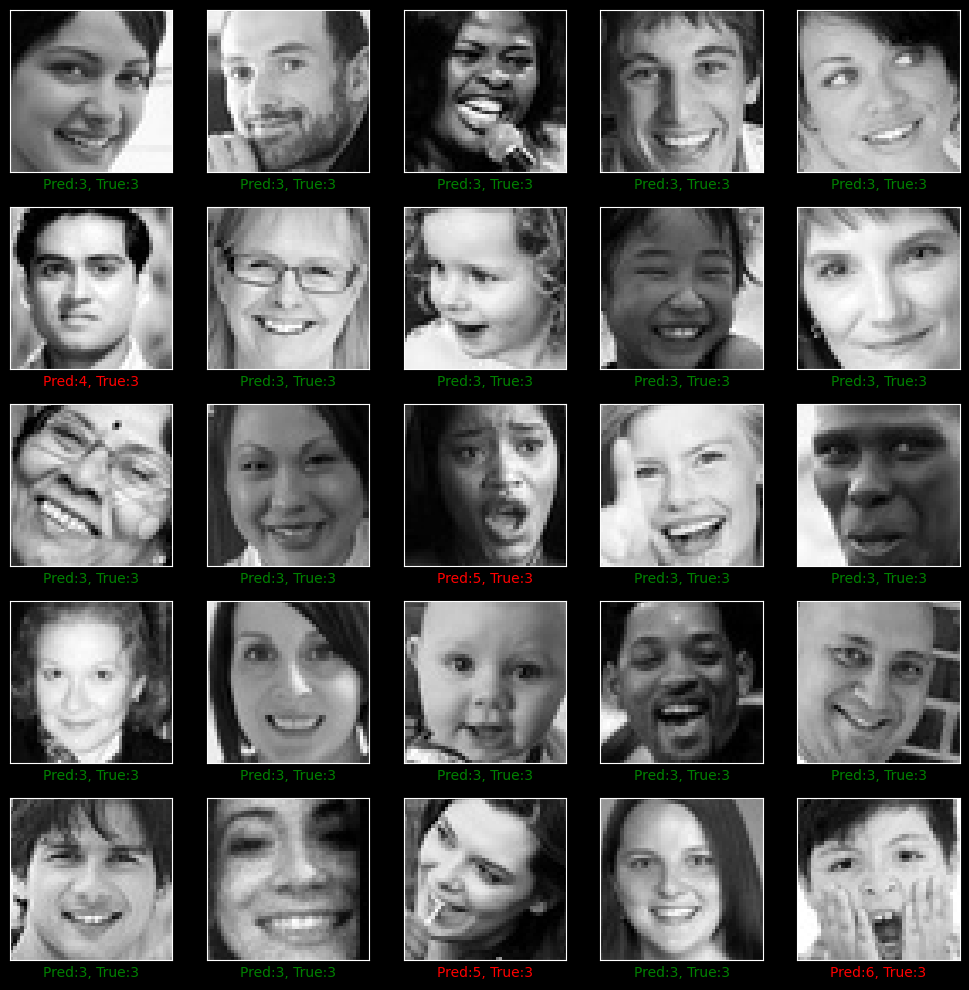

In [ ]:
predictions = model.predict(x_test)
true_labels = np.argmax(y_test, axis = 1)

plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = x_test[i]
    if image.ndim == 3 and image.shape[-1] == 1:
        image = image.squeeze()

    plt.imshow(image, cmap = 'gray')

    predicted_label = np.argmax(predictions[i])
    true_label = true_labels[i]

    color = 'green' if predicted_label == true_label else 'red'
    plt.xlabel(f"Pred:{predicted_label}, True:{true_label}", color = color)

plt.tight_layout()
plt.show()


In [ ]:
y_pred_classes = np.argmax(predictions, axis=1)

y_true_classes = np.argmax(y_test, axis=1)

<h1> Model Evaluation Results

---
- Description:
The final trained model is evaluated on a separate test dataset using classification metrics such as precision, recall, F1-score, and overall accuracy.

- Purpose :
To assess the model's real-world performance in recognizing facial expressions and ensure it generalizes well beyond the training data.

 📊 Results :

        🔹 Overall Accuracy : 63.33%
        🔹 Best Class Performance : Happy (Precision : 0.79 , Recall : 0.86 , F1-Score : 0.82)
        🔹 Challenging Classes : Fear and Disgust showed lower recall and F1-scores, indicating potential confusion or class imbalance.

In [ ]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(classification_report(y_true_classes, y_pred_classes, target_names = class_names))

acc = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {acc:.4f}")

              precision    recall  f1-score   support

       Angry       0.55      0.54      0.54       958
     Disgust       0.83      0.53      0.65       111
        Fear       0.60      0.33      0.43      1018
       Happy       0.79      0.86      0.82      1825
         Sad       0.53      0.62      0.57      1216
    Surprise       0.47      0.57      0.52      1138
     Neutral       0.80      0.76      0.78       797

    accuracy                           0.63      7063
   macro avg       0.65      0.60      0.62      7063
weighted avg       0.64      0.63      0.63      7063

Accuracy: 0.6333


<h1> Visualizing Model Performance with a Confusion Matrix

---

- Description :
A confusion matrix is plotted to show how predictions align with actual emotion classes.
- Purpose :
To analyze which emotions the model confuses and assess per-class performance.

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
z_text = [[str(cell) for cell in row] for row in cm]


fig = go.Figure(data = go.Heatmap( z = cm, x = class_names, y = class_names, text = z_text, texttemplate = "%{text}", textfont = {"size": 12, "color": "black"},
                                  colorscale = 'Blues', hovertemplate = 'True: %{y}<br>Predicted: %{x}<br>Count: %{z}<extra></extra>'))

fig.update_layout(title = dict(text = "<b>Confusion Matrix</b>" , x = 0.5, xanchor = 'center', font = dict(size = 20, family = 'Arial', color = 'black')),
                   xaxis_title = "<b>Predicted Labels</b>",
                   yaxis_title = "<b>True Labels</b>",
                   xaxis = dict(tickfont = dict(size = 12), title_font = dict(size = 14, family = 'Arial', color = 'black')),
                   yaxis = dict(tickfont = dict(size = 12), title_font = dict(size = 14, family = 'Arial', color = 'black'), autorange = 'reversed'),
                   template = 'plotly_white')

fig.show()


<h1> Model Performance Evaluation Using Classification Report

---

- Description : This bar chart shows the precision, recall, and F1-score for each emotion class predicted by the model.
- Purpose : To evaluate how well the model performs across different emotions using key classification metrics.

In [ ]:
del zip

In [ ]:
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
accuracy = accuracy_score(y_true_classes, y_pred_classes)

df = pd.DataFrame(report).transpose()
df = df.loc[class_names]

fig = go.Figure()

metrics = ['precision', 'recall', 'f1-score']
colors = ['#EF553B', '#00CC96', '#636EFA']


for i, (metric, color) in enumerate(zip(metrics, colors)):
    fig.add_trace(go.Bar(x = class_names, y = df[metric], name = metric.capitalize(), marker_color = color, text = [f"{val:.2f}" for val in df[metric]], textposition = 'outside', textfont = dict(size = 12)))


fig.update_layout(title = dict(text = f"<b>Classification Report (Accuracy: {accuracy:.2%})</b>", x = 0.5, xanchor = 'center', font = dict(size = 18)),
                  xaxis_title = "<b>Emotion Classes</b>",
                  yaxis_title = "<b>Score</b>",
                  yaxis = dict(range = [0, 1]),
                  barmode = 'group',
                  legend_title = "<b>Metrics</b>",
                  template = "plotly_white")

fig.show()


<h1> Saved The Model

---



In [ ]:
model.save("face_recognition_model.h5")
print("Model saved as my_model.h5")

Model saved as my_model.h5
